# Play Store Sentiment Review (Naive Bayes)

In [56]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pickle import dump
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer


In [6]:
df = pd.read_csv('../data/processed/playstore_reviews_processed.csv')
df.sample(10)

,review,polarity
815,thanks u so much for adding sanshkar fm kalai...,1
682,lacks caps lock function because there is no ...,1
613,nice app i suggest you to add a word-count fe...,1
649,brilliant app brilliant app for browsing and ...,1
850,really useful app.. đđđđ,1
237,hasn't loaded in almost 16 days. have played...,0
732,update sucks!!! it has become so slow now tha...,0
76,i hated it i am able to log in successfully b...,0
450,doesn't refresh properly i added a few contac...,0
608,"new user, great app. have suggestions so far,...",1


In [26]:
X = df['review']
y = df['polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712,), (179,), (712,), (179,))

To train a Naive Bayes model, the predictors must be numerical. Thus, the text will be converted into a weight count matrix using Term Frequency–Inverse Document Frequency

In [41]:
# Vectorize data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((712, 3304), (179, 3304))

In this case, the target is binary and BernoulliNb could be use. Although, the features in this case represent ponderated frecuencies, therefore, the MultinomialNB implementation will be used.  

In [57]:
def metrics_scores(y_test, y_hat):
    # Accuracy and classification report
    display('Accuracy score:', accuracy_score(y_test, y_hat))
    display(classification_report(y_test, y_hat))

    cm = confusion_matrix(y_test, y_hat)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['polarity'].unique())
    disp.plot(cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.show()

'Accuracy score:'

0.7262569832402235

'              precision    recall  f1-score   support\n\n           0       0.72      0.98      0.83       120\n           1       0.86      0.20      0.33        59\n\n    accuracy                           0.73       179\n   macro avg       0.79      0.59      0.58       179\nweighted avg       0.76      0.73      0.66       179\n'

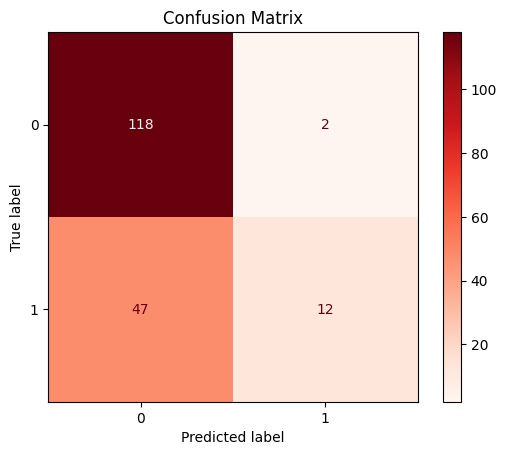

In [58]:
# Machine Learning
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_hat = nb.predict(X_test_vec)

metrics_scores(y_test, y_hat)

This model has an accuracy of 0.72. It has almost a perfect recall for reviews with polarity of 0. Although for reviews with polarity of 1 it has a poor performance with a recall of 0.2. Further optimization is required. 

Another type of vectorization for the reviews is the CountVectorizer which just counts how many times each word has appeared in the review, it does not penalize frequent words, but it can be another alternative to vectorizing the text. 

'Accuracy score:'

0.8100558659217877

'              precision    recall  f1-score   support\n\n           0       0.82      0.92      0.87       120\n           1       0.78      0.59      0.67        59\n\n    accuracy                           0.81       179\n   macro avg       0.80      0.75      0.77       179\nweighted avg       0.81      0.81      0.80       179\n'

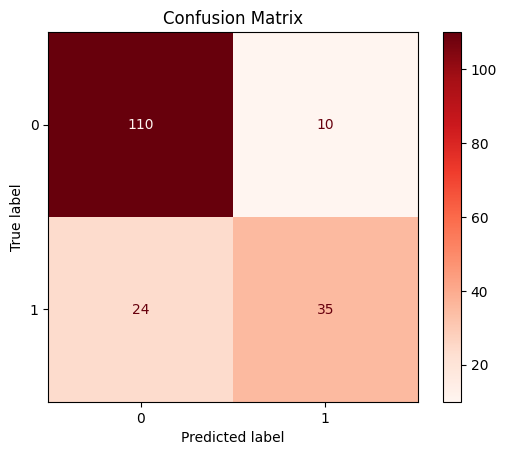

In [60]:
# Naive Bayes version 2
pipe = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

nv_v2 = pipe.fit(X_train, y_train)

y_hat_v2 = nb_v2.predict(X_test)

metrics_scores(y_test, y_hat_v2)

This model with the other type of word vectorizer has an accuracy of 0.81, which is almost 0.1 more than the last model. It also has much better recall for the 1 label, and although it has lower recall in the 0 label, it can be outweighted by the fact that it has better accuracy and both polarities have better f1 score. This model will be the one optimized.

In [61]:
param_grid = {
    'nb__alpha': [0.1, 0.5, 1.0, 2.0],
    'nb__fit_prior': [True, False]
}

nb_cv = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
)

nb_cv.fit(X_train, y_train)

display('Best params: ', nb_cv.best_params_)

'Best params: '

{'nb__alpha': 0.5, 'nb__fit_prior': False}

'Accuracy score:'

0.8268156424581006

'              precision    recall  f1-score   support\n\n           0       0.86      0.89      0.87       120\n           1       0.76      0.69      0.73        59\n\n    accuracy                           0.83       179\n   macro avg       0.81      0.79      0.80       179\nweighted avg       0.82      0.83      0.82       179\n'

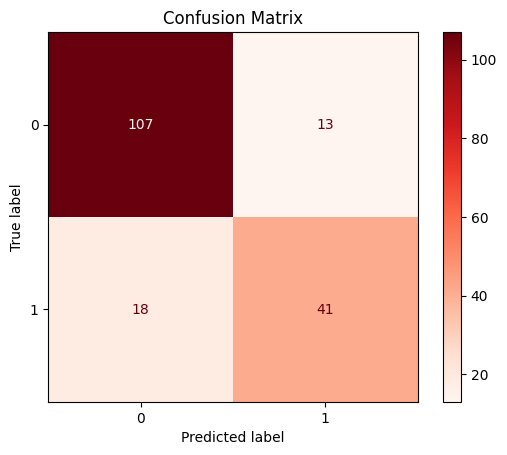

In [ ]:
# Prediction with best parameters
nb_tuned = nb_cv.best_estimator_
y_hat_tuned = nb_tuned.predict(X_test)

# Accuracy and classification report
metrics_scores(y_test, y_hat_tuned)

This tuned model has improved by 0.01. The recall in the 0 label is lower but in the 1 label is higher. Both have a good f1 score with respect to the past models.

In [63]:
# Save models
dump(nb, open('../models/nb_model_raw.sav', 'wb'))
dump(nb_tuned, open('../models/nb_tuned_model.sav', 'wb'))